<a href="https://colab.research.google.com/github/PrachiKhatri22/PetClassify-Classification-Using-TensorFlow-CNN/blob/main/PetClassify_Classification_Using_TensorFlow_CNNipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install split-folders

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torchsummary import summary
import splitfolders
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Define transforms

In [ ]:
# transform = transforms.Compose([transforms.ToTensor()])
# Resize images to 64x64
transform = transforms.Compose([
    transforms.Resize((64, 64)),transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize([0.5]*3, [0.5]*3) # Normalizing
])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Humber Sem-2/Image Processing/Assign07

/content/drive/MyDrive/Humber Sem-2/Image Processing/Assign07


## Prepare train and test sets, loaders

In [ ]:
splitfolders.ratio("CatDog", output="Output",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False) # default values

Copying files: 4000 files [02:59, 22.25 files/s]


In [ ]:
train_data = datasets.ImageFolder('Output/train', transform = transform)
test_data = datasets.ImageFolder('Output/val', transform = transform)

In [ ]:
train_loader = DataLoader(train_data, batch_size = 32, shuffle=True,  drop_last = True)
test_loader = DataLoader(test_data, batch_size= 32,  drop_last = True)

class_names = train_data.classes # classes or labels or categories

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['cat', 'dog']
Training images available: 3199
Testing images available:  801


## Display a batch of images


In [ ]:
for images,labels in train_loader:
    break
images.shape

torch.Size([32, 3, 64, 64])

In [ ]:
labels

tensor([0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
        1, 1, 0, 1, 0, 0, 0, 0])

In [ ]:
test = len(test_data)
test

801

Label: [0 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0]
Class: cat dog cat dog dog dog dog dog cat dog cat dog dog dog cat dog dog cat dog cat cat cat cat cat dog dog cat dog cat cat cat cat


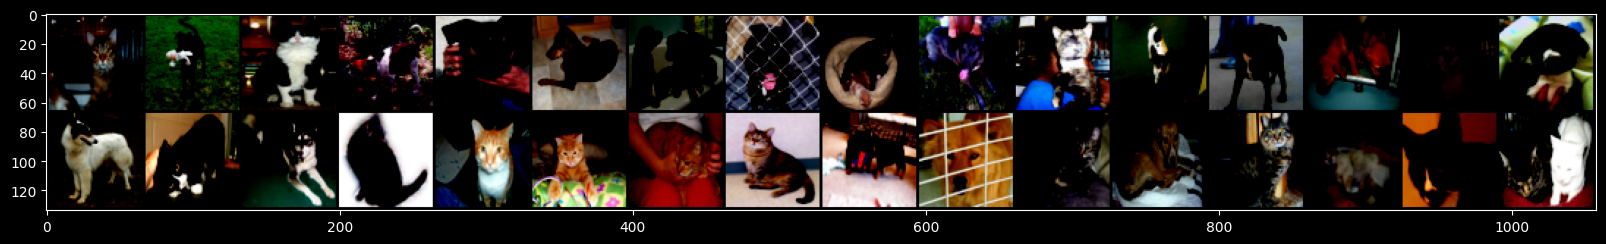

In [ ]:
# Print the labels

print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=16)  # 16 images in a row. the default nrow is 8

# Print the images

plt.figure(figsize=(20,16))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0))); # we see that dataloader has shuffle the images

##  Using Transfer Learning

In [ ]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 61.8MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Setting Early Stopping Criterion

In [ ]:
class EarlyStoppingCriterion():
    def __init__(self, patience = 3, delta = 0,  trace_func = print):

        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score

        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# Training and Testing the model

In [ ]:
  test= len(test_data)
  epochs = 10
  n_classes = 2
  batchsize = 32
  model.to(device)
  lossfun = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)
# Instantiating the early stopping
  earlystopping = EarlyStoppingCriterion()


  # initialize losses
  losses    = torch.zeros(epochs)
  trainAcc  = []
  testAcc   = []


  for epoch in range(epochs):
    model.train()

    # loop over training batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      X = X.to(device)
      y = y.to(device)

      ypred = model(X.float())
      loss = lossfun(ypred,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
      ypred = ypred.cpu()
      y = y.cpu()

      # compute accuracy
      matches = torch.argmax(ypred,axis=1) == y
      matchesNumeric = matches.float()
      accuracyPct = 100*torch.mean(matchesNumeric)
      batchAcc.append( accuracyPct )


    # Average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # Average losses across the batches
    losses[epoch] = np.mean(batchLoss)

    # test the model

    model.eval()

    with torch.no_grad(): # deactivates autograd
     batchAcc_test = []
     y_pred = np.zeros((test // batchsize , batchsize, n_classes))
     y_true = np.zeros((test // batchsize , batchsize))
     testbatch_losses = [] # This is new calculation

     for idx, (X,y) in enumerate(test_loader):

      X = X.to(device)
      y = y.to(device)
      ypred_t = model(X)
      ypred_t = ypred_t.cpu()
      y_pred[idx,:,:] = ypred_t
      y = y.cpu()
      y_true[idx,:] = y
      tloss = lossfun(ypred_t, y)
      # record test loss
      testbatch_losses.append(tloss.item())

      matches = torch.argmax(ypred_t,axis=1) == y
      matchesNumeric = matches.float()
      accuracyPct = 100*torch.mean(matchesNumeric)
      batchAcc_test.append( accuracyPct )

    testAcc.append( np.mean(batchAcc_test) )
    epoch_len = len(str(epochs))

    print_msg = (f'[{epoch:>{epoch_len}}/{epochs:>{epoch_len}}] ' +

                     f'test_loss: {np.mean(testbatch_losses):.5f}')

    print(print_msg)

    earlystopping(np.mean(testbatch_losses), model)

    if earlystopping.early_stop:
        print("Early stopping")
        break



[ 0/10] test_loss: 0.31386
[ 1/10] test_loss: 0.21364
[ 2/10] test_loss: 0.17066
[ 3/10] test_loss: 0.14596
[ 4/10] test_loss: 0.13074
[ 5/10] test_loss: 0.12050
[ 6/10] test_loss: 0.11348
[ 7/10] test_loss: 0.10309
[ 8/10] test_loss: 0.09977
[ 9/10] test_loss: 0.09570


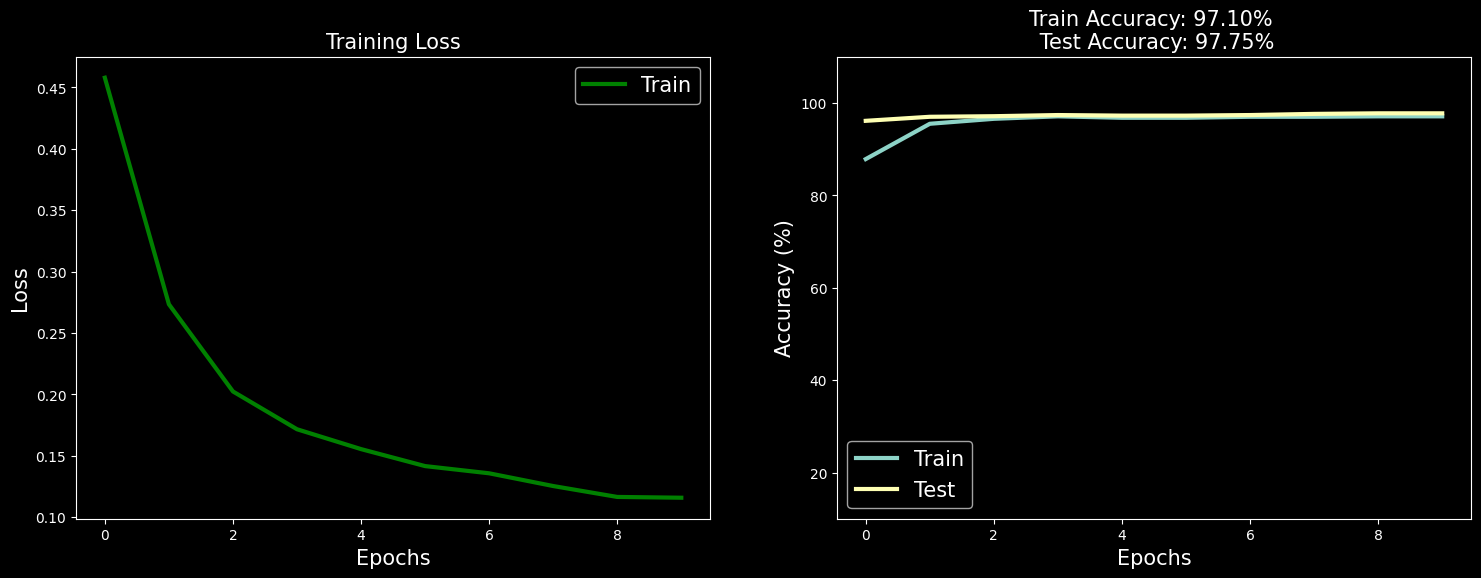

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(losses, 'g', lw = 3, label = 'Train')
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(fontsize = 15)
ax[0].set_title('Training Loss', fontsize = 15)

ax[1].plot(trainAcc, label ='Train', lw = 3)
ax[1].plot(testAcc, label ='Test', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()

In [ ]:
from PIL import Image

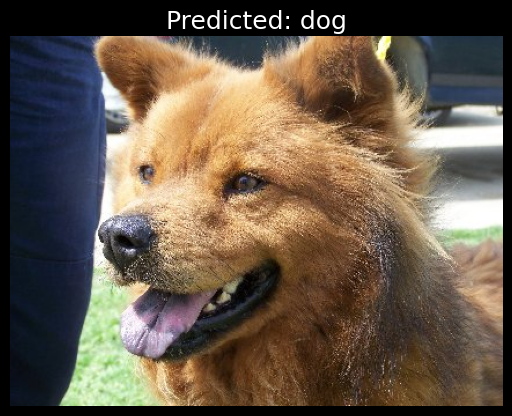

In [ ]:
# Load the image
image_path = '/content/drive/MyDrive/Humber Sem-2/Image Processing/Assign07/Output/val/dog/45.jpg'
image = Image.open(image_path)

# Apply the transformation and add an extra dimension to handle the batch size
image_tensor = transform(image).unsqueeze(0).to(device)  # Move tensor to the correct device

# Assuming 'model' is already defined and loaded with the trained weights
# Make sure the model is in evaluation mode and moved to the correct device
model.eval().to(device)

# Disable gradient computation for inference
with torch.no_grad():
    output = model(image_tensor)

# Get the predicted class
_, predicted_class = torch.max(output, 1)
class_names = ['cat', 'dog']
predicted_label = class_names[predicted_class.item()]

# Display the image along with the predicted label
plt.imshow(image)
plt.title(f'Predicted: {predicted_label}')
plt.axis('off')
plt.show()